# Clustering Consulting Project 

A large technology firm needs your help, they've been hacked! Luckily their forensic engineers have grabbed valuable data about the hacks, including information like session time,locations, wpm typing speed, etc. The forensic engineer relates to you what she has been able to figure out so far, she has been able to grab meta data of each session that the hackers used to connect to their servers. These are the features of the data:

* 'Session_Connection_Time': How long the session lasted in minutes
* 'Bytes Transferred': Number of MB transferred during session
* 'Kali_Trace_Used': Indicates if the hacker was using Kali Linux
* 'Servers_Corrupted': Number of server corrupted during the attack
* 'Pages_Corrupted': Number of pages illegally accessed
* 'Location': Location attack came from (Probably useless because the hackers used VPNs)
* 'WPM_Typing_Speed': Their estimated typing speed based on session logs.


The technology firm has 3 potential hackers that perpetrated the attack. Their certain of the first two hackers but they aren't very sure if the third hacker was involved or not. They have requested your help! Can you help figure out whether or not the third suspect had anything to do with the attacks, or was it just two hackers? It's probably not possible to know for sure, but maybe what you've just learned about Clustering can help!

**One last key fact, the forensic engineer knows that the hackers trade off attacks. Meaning they should each have roughly the same amount of attacks. For example if there were 100 total attacks, then in a 2 hacker situation each should have about 50 hacks, in a three hacker situation each would have about 33 hacks. The engineer believes this is the key element to solving this, but doesn't know how to distinguish this unlabeled data into groups of hackers.**

In [29]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()

In [30]:
from pyspark.ml.clustering import KMeans

# Loads data.
dataset = spark.read.csv("hack_data.csv",header=True,inferSchema=True)

In [31]:
dataset.head()

Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37)

In [32]:
dataset.describe().show()

+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       null|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       null| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|Afghanistan|              40.0|
|    max|           

In [33]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [34]:
dataset.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [35]:
from pyspark.ml.feature import VectorAssembler

In [36]:
vec_assembler = VectorAssembler(inputCols = ['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed'], outputCol='features')

In [37]:
final_data = vec_assembler.transform(dataset)

In [38]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [39]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [40]:
final_data = scalerModel.transform(final_data)

In [41]:
kmeans2 = KMeans(featuresCol='scaledFeatures',k=2)
model2 = kmeans2.fit(final_data)
kmeans3 = KMeans(featuresCol='scaledFeatures',k=3)
model3 = kmeans3.fit(final_data)

In [42]:
wssse2 = model2.computeCost(final_data)
print("Within Set Sum of Squared Errors = " + str(wssse2))
wssse3 = model3.computeCost(final_data)
print("Within Set Sum of Squared Errors = " + str(wssse3))

Within Set Sum of Squared Errors = 601.7707512676716
Within Set Sum of Squared Errors = 434.75507308487647


In [43]:
centers2 = model2.clusterCenters()
print("Cluster Centers: ")
for center in centers2:
    print(center)
    
centers3 = model3.clusterCenters()
print("Cluster Centers: ")
for center in centers3:
    print(center)

Cluster Centers: 
[1.26023837 1.31829808 0.99280765 1.36491885 2.5625043  5.26676612]
[2.99991988 2.92319035 1.05261534 3.20390443 4.51321315 3.28474   ]
Cluster Centers: 
[2.93719177 2.88492202 0.         3.19938371 4.52857793 3.30407351]
[1.26023837 1.31829808 0.99280765 1.36491885 2.5625043  5.26676612]
[3.05623261 2.95754486 1.99757683 3.2079628  4.49941976 3.26738378]


In [44]:
model2.transform(final_data).select('prediction').show()

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 20 rows



In [45]:
model3.transform(final_data).select('prediction').show()

+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
+----------+
only showing top 20 rows



In [46]:
model2.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



In [47]:
model3.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         2|   88|
|         0|   79|
+----------+-----+



<h1>ONLY 2 HACKERS ARE INVOLVED IN THIS</h2>

In [48]:
import numpy as np

In [49]:
cost = np.zeros(20)
for k in range(2,20):
    print(k)
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(final_data)
    cost[k] = model.computeCost(final_data)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


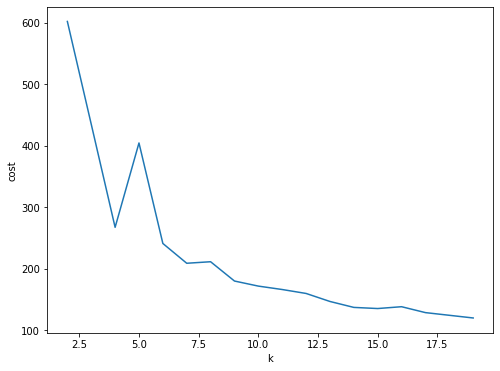

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()